# AirBnB : Part 2, Exploratory Data Analysis

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import chi2,f_classif
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.grid_search import GridSearchCV

from xgboost import XGBClassifier

from utils import rstr,distance

airBColor= '#ff5a5f'
airBColor2= '#008489'

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df_listing = pd.read_csv('../../data/listing_cleansed.csv')
df_reviews_PCA = pd.read_csv('../../data/df_listings_with_reviews_PCA.csv')
df_pictures_PCA = pd.read_csv('../../data/df_listing_active_with_pic.csv')
df_listing= pd.merge(df_listing,df_reviews_PCA,on='listing_id')
df_listing= pd.merge(df_listing,df_pictures_PCA,on='listing_id')
df_reviews_freq=pd.read_csv('../../data/reviews_frequency.csv')
df_listing = pd.merge(df_listing,df_reviews_freq,on='listing_id')
df_listing.host_id.isnull().sum()

0

In [3]:
df_review_with_lang = pd.read_csv('../../data/reviews_with_lang.csv',index_col=0)
groupy_lang_review = df_review_with_lang.groupby(['listing_id','language'])[['id']].count().unstack().fillna(0)
groupy_lang_review.columns = groupy_lang_review.columns.droplevel()
groupy_lang_review = groupy_lang_review.reset_index()
groupy_lang_review=groupy_lang_review.astype(int)

groupy_lang_review.iloc[:, 1:] = groupy_lang_review.iloc[:, 1:].apply(lambda x: x*100.0 / x.sum(),axis=1)


cols_ratio_lang = ['review_ratio_'+c for c in groupy_lang_review.columns.tolist()[1:]]
groupy_lang_review.columns = ['listing_id']+cols_ratio_lang


In [4]:
groupy_lang_review.head()

,listing_id,review_ratio_No found,review_ratio_af,review_ratio_bg,review_ratio_ca,review_ratio_cs,review_ratio_cy,review_ratio_da,review_ratio_de,review_ratio_el,...,review_ratio_so,review_ratio_sv,review_ratio_sw,review_ratio_th,review_ratio_tl,review_ratio_tr,review_ratio_uk,review_ratio_vi,review_ratio_zh-cn,review_ratio_zh-tw
0,1971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.242424,0.0,...,0.0,1.515152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.293706,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_listing = pd.merge(df_listing,groupy_lang_review,on='listing_id')

### Filter on numeric features

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_listing = df_listing.select_dtypes(include=numerics)

### Remove listing with no reviews

In [7]:
df_listing = df_listing[df_listing.availability_90>0]

In [8]:
df_listing.shape

(4448, 633)

### Fill missing data

In [9]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent
host_response_time,2.787770
host_response_rate,2.787770
review_scores_value,0.764388
review_scores_location,0.741906
review_scores_checkin,0.741906
review_scores_accuracy,0.696942
review_scores_communication,0.696942
review_scores_cleanliness,0.629496
review_scores_rating,0.607014
bathrooms,0.359712


### Replace abnormal values and missing data

In [10]:
df_listing.loc[df_listing['maximum_nights'] > 365, 'maximum_nights'] = 365

In [11]:
columns_fill_na_with_mean = df_missing_data.index
df_listing[columns_fill_na_with_mean]= df_listing[columns_fill_na_with_mean].fillna(df_listing[columns_fill_na_with_mean].mean())

In [12]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


### Add distance to Berlin center

In [13]:
coord_brandenburg_tor = (52.516849,13.377661)
def distance_highlight(x):
    return distance(coord_brandenburg_tor,x)

In [14]:
df_listing['coordinate']=list(zip(df_listing.latitude, df_listing.longitude))
df_listing['distance_brandenburg_tor'] = df_listing['coordinate'].apply(distance_highlight)
df_listing.drop('coordinate',axis=1,inplace=True)

### Add target label

In [15]:
TARGET = 'is_multihost'

In [16]:
df_listing['listings_per_host']=df_listing.groupby(["host_id"])["listing_id"].transform("count")
df_listing[TARGET]=( df_listing.listings_per_host>1)*1

### Split Features and Target 

In [17]:
y = df_listing[TARGET]
X = df_listing.drop([TARGET,'listing_id','host_id','host_listings_count','listings_per_host'],axis=1)

### Drop zero variance and Scale X 

In [18]:
print X.shape
X = X.loc[:, X.std()>0]
print X.shape

(4448, 631)
(4448, 620)


In [19]:
X = X.apply(lambda x: MinMaxScaler().fit_transform(x),axis=0)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

In [20]:
print X.shape,y.shape

(4448, 620) (4448,)


### Selection using RandomizedLogisticRegression_selector

In [21]:
def RandomizedLogisticRegression_selector(X,y):
    clf = RandomizedLogisticRegression()
    columns = X.columns
    clf.fit(X,y)
    idx =  clf.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [22]:
features_RLR = RandomizedLogisticRegression_selector(X,y)

In [23]:
features_RLR

['host_since',
 'host_response_time',
 'is_location_exact',
 'accommodates',
 'beds',
 'guests_included',
 'maximum_nights',
 'availability_365',
 'review_scores_rating',
 'review_scores_communication',
 'review_scores_value',
 'instant_bookable',
 'require_guest_phone_verification',
 'reviews_per_month',
 'amenities__24hourcheckin',
 'amenities__Buzzerwirelessintercom',
 'amenities__Familykidfriendly',
 'amenities__Fireextinguisher',
 'amenities__Hangers',
 'amenities__Laptopfriendlyworkspace',
 'amenities__Smokingallowed',
 'amenities__Suitableforevents',
 'amenities__TV',
 'amenities__Washer',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'host_verification_kba',
 'neighbourhood_group_cleansed__Mitte',
 'property_type__Servicedapartment',
 'availability_365_previous_month',
 'reviews_PC_3',
 'reviews_PC_4',
 'reviews_PC_9',
 'reviews_PC_10',
 'reviews_PC_11',
 'pictures_PC_1',
 'pictures_PC_2',
 'Centroid_R_3',
 'Brightness_

### Selection using KbestSelection

In [24]:
def SelectKBest_features(X,y,method, n_features):
    selector = SelectKBest(method, k=n_features)
    selector.fit(X, y)
    # Get idxs of columns to keep
    idx =  selector.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [25]:
features_Kbest_chi2 = SelectKBest_features(X,y,chi2,50)
features_Kbest_fclass = SelectKBest_features(X,y,f_classif,50)

In [26]:
features_Kbest_chi2

['host_response_time',
 'is_location_exact',
 'accommodates',
 'beds',
 'guests_included',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_phone_verification',
 'reviews_per_month',
 'amenities__24hourcheckin',
 'amenities__Breakfast',
 'amenities__Elevatorinbuilding',
 'amenities__Familykidfriendly',
 'amenities__Fireextinguisher',
 'amenities__Hangers',
 'amenities__Keypad',
 'amenities__Laptopfriendlyworkspace',
 'amenities__Lockbox',
 'amenities__Petsallowed',
 'amenities__Safetycard',
 'amenities__SelfCheckIn',
 'amenities__Smokedetector',
 'amenities__Smokingallowed',
 'amenities__Suitableforevents',
 'amenities__TV',
 'amenities__Washer',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'host_verification_facebook',
 'host_verification_kba',
 'neighbourhood_group_cleansed__Mitte',
 'neighbourhood_group_cleansed__Neuklln',
 'property_type__Servicedapa

In [27]:
features_Kbest_fclass

['host_response_time',
 'host_response_rate',
 'is_location_exact',
 'accommodates',
 'beds',
 'price',
 'guests_included',
 'maximum_nights',
 'availability_30',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_value',
 'instant_bookable',
 'cancellation_policy',
 'reviews_per_month',
 'amenities__24hourcheckin',
 'amenities__Familykidfriendly',
 'amenities__Fireextinguisher',
 'amenities__Hangers',
 'amenities__Smokedetector',
 'amenities__TV',
 'amenities__Washer',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'neighbourhood_group_cleansed__Mitte',
 'availability_365_previous_month',
 'availability_60_previous_month',
 'availability_90_previous_month',
 'reviews_PC_1',
 'reviews_PC_3',
 'reviews_PC_4',
 'reviews_PC_11',
 'pictures_PC_1',
 'pictures_PC_2',
 'Centroid_R_3',
 'Brightness_mean',
 'reviewed_more

### Selection using Xgboost

In [28]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

In [29]:
params = {
    'max_depth':[9],
    'min_child_weight':[2],
    'learning_rate' :[0.1],
    'gamma':[0.0],
    'n_estimators':[100]
}

clf = XGBClassifier()

best_clf = cv_optimize(clf,params,X,y)

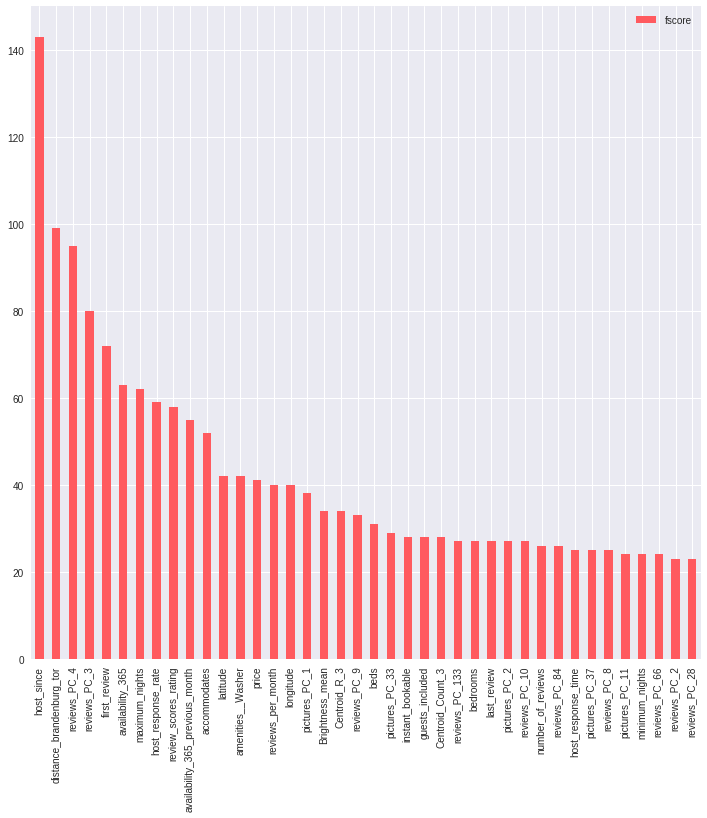

In [30]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

In [31]:
XGB_features = features_weights.sort_values(by='fscore',ascending=False).head(30).index.tolist()


### Plot best  5 features from Kbest fclass

In [32]:
df_scatter_plot = X[XGB_features[:5]]
df_scatter_plot['is_multihost']=y

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [33]:
df_scatter_plot.columns = [f.replace("amenities__translationmissingenhosting","") for f in df_scatter_plot.columns]

In [34]:
df_scatter_plot.columns

Index([u'host_since', u'distance_brandenburg_tor', u'reviews_PC_4',
       u'reviews_PC_3', u'first_review', u'is_multihost'],
      dtype='object')

In [35]:
good_features = df_scatter_plot.columns.tolist()

good_features.remove('is_multihost')

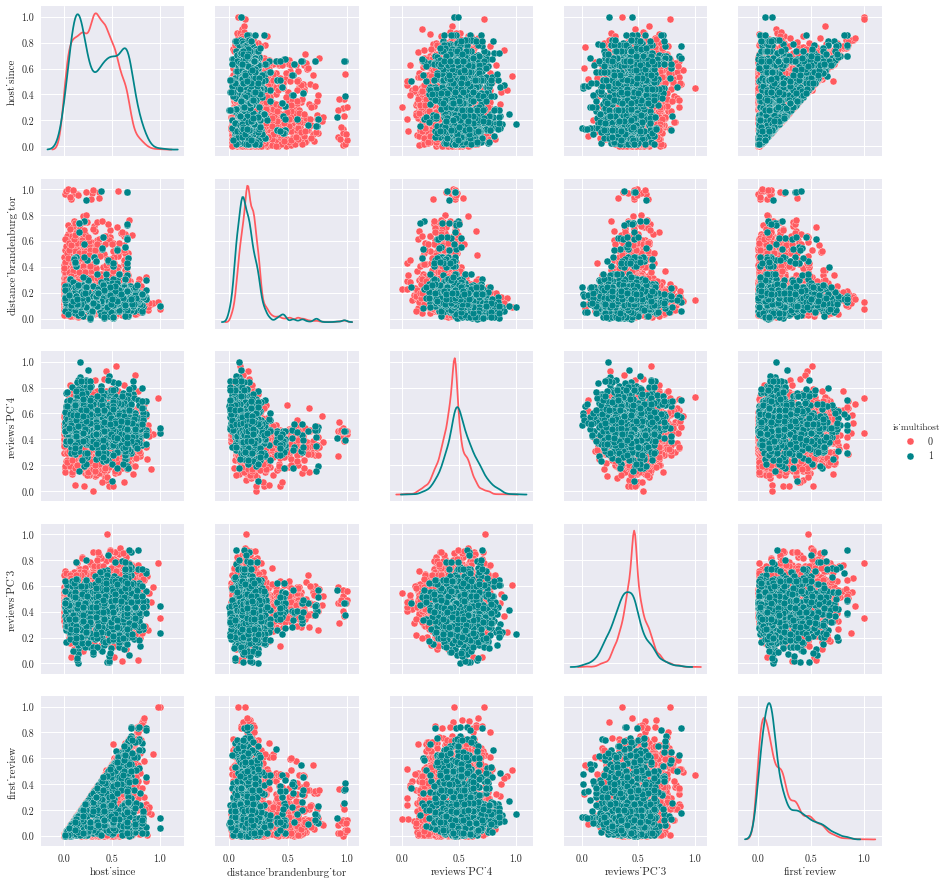

In [36]:
sns.set_style("darkgrid", { 'font.family': ['cmr10']})
sns.pairplot(df_scatter_plot, hue="is_multihost",diag_kind='kde',vars=good_features,palette={0:airBColor,1:airBColor2})


### Create a list of the overall best features

In [38]:
BEST_FEATURES = list(set(features_RLR+XGB_features+features_Kbest_chi2+features_Kbest_fclass+['latitude','longitude']))
len(BEST_FEATURES)

80

In [39]:
BEST_FEATURES

['reviewed_more_than_90_ago',
 'reviews_per_month',
 'host_verification_kba',
 'first_review',
 'availability_60_previous_month',
 'pictures_PC_2',
 'pictures_PC_1',
 'amenities__Lockbox',
 'reviewed_more_than_70_ago',
 'amenities__Petsallowed',
 'availability_90_previous_month',
 'neighbourhood_group_cleansed__Mitte',
 'review_scores_communication',
 'longitude',
 'is_location_exact',
 'review_ratio_de',
 'amenities__Laptopfriendlyworkspace',
 'availability_365',
 'reviewed_more_than_60_ago',
 'amenities__Hangers',
 'reviews_PC_2',
 'reviewed_more_than_20_ago',
 'amenities__SelfCheckIn',
 'require_guest_phone_verification',
 'Centroid_R_3',
 'host_since',
 'reviewed_more_than_100_ago',
 'pictures_PC_33',
 'reviewed_more_than_14_ago',
 'property_type__Servicedapartment',
 'amenities__Smokingallowed',
 'reviewed_more_than_7_ago',
 'maximum_nights',
 'cancellation_policy',
 'amenities__TV',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenit

In [40]:
df_dataset_for_modeling = pd.concat([y,X[BEST_FEATURES]],axis=1)

In [41]:
df_dataset_for_modeling.to_csv('../../data/dataset_for_modeling.csv',index=None)

In [42]:
df_dataset_for_modeling.head()

,is_multihost,reviewed_more_than_90_ago,reviews_per_month,host_verification_kba,first_review,availability_60_previous_month,pictures_PC_2,pictures_PC_1,amenities__Lockbox,reviewed_more_than_70_ago,...,accommodates,beds,reviewed_more_than_30_ago,host_response_rate,amenities__24hourcheckin,guests_included,amenities__Suitableforevents,review_scores_checkin,Brightness_mean,amenities__Fireextinguisher
0,0,0.0,0.059686,0.0,0.052138,0.283333,0.323760,0.379248,0.0,0.111111,...,0.200000,0.066667,0.0,1.000000,0.0,0.071429,0.0,0.625,0.600000,0.0
1,0,0.0,0.002094,0.0,0.468891,0.383333,0.438955,0.783363,0.0,0.000000,...,0.200000,0.066667,0.0,0.917824,0.0,0.071429,0.0,0.750,0.214634,0.0
2,0,0.0,0.063874,0.0,0.214112,0.216667,0.463203,0.531854,0.0,0.000000,...,0.333333,0.200000,0.0,1.000000,0.0,0.214286,0.0,1.000,0.453659,0.0
3,0,0.0,0.097382,0.0,0.020855,0.200000,0.346078,0.661283,0.0,0.000000,...,0.066667,0.066667,0.0,1.000000,0.0,0.000000,0.0,1.000,0.307317,0.0
4,0,0.0,0.011518,0.0,0.081682,0.966667,0.238814,0.439461,0.0,0.000000,...,0.333333,0.333333,0.0,1.000000,1.0,0.000000,0.0,1.000,0.531707,0.0
